# Loan Default Prediction
## Team Members:
* Harish Puvvada
* Vamsi Mohan Ramineedi

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing,metrics 
from IPython.core.display import HTML
pd.set_option("display.max_columns",75)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.__version__

'0.20.1'

In [3]:
df2012_13 = pd.read_csv(os.getenv('FDS')+'LoanStats_2012_to_2013.csv',low_memory=False,skiprows=1)
df2014 = pd.read_csv(os.getenv('FDS')+'LoanStats_2014.csv',low_memory=False,skiprows=1)

## Data Cleaning

In [4]:
dataset = pd.concat([df2012_13, df2014]) #merging 2007 to 2014 datasets
dataset = dataset.iloc[:,2:111]          #removing empty columns
empty_cols = [i for i in range(45,72)]   #more empty columns
dataset = dataset.drop(dataset.columns[empty_cols],axis=1)
data_with_loanstatus_sliced = dataset[(dataset['loan_status']=="Fully Paid") | (dataset['loan_status']=="Charged Off")]
di = {"Fully Paid":0, "Charged Off":1}   #converting target variable to boolean
Dataset_withBoolTarget= data_with_loanstatus_sliced.replace({"loan_status": di})

In [5]:
Dataset_withBoolTarget['loan_status'].value_counts()
Dataset_withBoolTarget.shape

(376233, 82)

In [6]:
#print(Dataset_withBoolTarget.shape)
dataset=Dataset_withBoolTarget.dropna(thresh = 340000,axis=1) #340000 is minimum number of non-NA values
#print(x.isnull().sum()) #- to check how many null values in all the columns
print(dataset.shape)

(376233, 74)


In [7]:
del_col_names = ["delinq_2yrs",  "last_pymnt_d", "chargeoff_within_12_mths","delinq_amnt","emp_title", "term", "emp_title", "pymnt_plan","purpose","title", "zip_code", "verification_status", "dti","earliest_cr_line", "initial_list_status", "out_prncp",
"pymnt_plan", "num_tl_90g_dpd_24m", "num_tl_30dpd", "num_tl_120dpd_2m", "num_accts_ever_120_pd", "delinq_amnt", 
"chargeoff_within_12_mths", "total_rec_late_fee", "out_prncp_inv", "issue_d"] #deleting some more columns
dataset = dataset.drop(labels = del_col_names, axis = 1) 
dataset.shape

(376233, 52)

In [8]:
features = ['funded_amnt','emp_length','annual_inc','home_ownership','grade',
            "last_pymnt_amnt", "mort_acc", "pub_rec", "int_rate", "open_acc","num_actv_rev_tl",
            "mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy",
            "avg_cur_bal","acc_open_past_24mths",'loan_status'] #selecting final features #'addr_state''tax_liens',
Final_data = dataset[features] #19 features with target var
Final_data["int_rate"] = Final_data["int_rate"].apply(lambda x:float(x[:-1]) ) #reomving % sign, conv to float  - int_rate column
Final_data= Final_data.reset_index(drop=True)
print(Final_data.shape)

(376233, 18)


## Data Transformation


In [9]:
#Data encoding
Final_data['grade'] = Final_data['grade'].map({'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1})
Final_data["home_ownership"] = Final_data["home_ownership"].map({"MORTGAGE":6,"RENT":5,"OWN":4,"OTHER":3,"NONE":2,"ANY":1})
Final_data["emp_length"] = Final_data["emp_length"].replace({'years':'','year':'',' ':'','<':'','\+':'','n/a':'0'}, regex = True)
Final_data["emp_length"] = Final_data["emp_length"].apply(lambda x:int(x))
Final_data.shape

(376233, 18)

## Filling Missing values and Feature scaling 


In [10]:
Final_data.fillna(Final_data.mean(),inplace = True)
HTML(Final_data.tail().to_html())
Final_data.shape

(376233, 18)

In [11]:
scl = preprocessing.StandardScaler() #instance of preprocessing
fields = Final_data.columns.values[:-1] 
data_clean = pd.DataFrame(scl.fit_transform(Final_data[fields]), columns = fields)
data_clean['loan_status'] = Final_data['loan_status']
data_clean['loan_status'].value_counts()

0    310035
1     66198
Name: loan_status, dtype: int64

In [13]:
loanstatus_0 = data_clean[data_clean["loan_status"]==0]
loanstatus_1 = data_clean[data_clean["loan_status"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=70000)
data_clean = pd.concat([loanstatus_1, subset_of_loanstatus_0])
data_clean = data_clean.sample(frac=1).reset_index(drop=True)

## Algorithms


In [14]:
#Random Forest Classifier
X_train, X_test, y_train, y_test = train_test_split(data_clean.iloc[:,:-1], data_clean.iloc[:,-1], test_size=0.33, random_state=42)
randomForest = RandomForestClassifier(criterion = "gini")
randomForest.fit(X_train,y_train)
rfPredict = randomForest.predict(X_test)
rfAccuracy = accuracy_score(y_test,rfPredict)
roc_score = metrics.roc_auc_score(y_test,rfPredict)
print(rfAccuracy,roc_score)

0.8214969074 0.821760214661


Text(0,0.5,'Normalized Gini Importance')

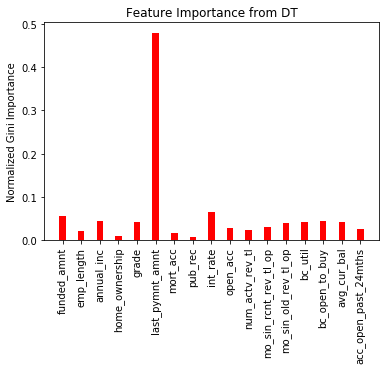

In [15]:
fig, ax = plt.subplots()
width=0.35
ax.bar(np.arange(len(fields)), randomForest.feature_importances_, width, color='r')
ax.set_xticks(np.arange(len(randomForest.feature_importances_)))
ax.set_xticklabels(X_train.columns.values,rotation=90)
plt.title('Feature Importance from DT')
ax.set_ylabel('Normalized Gini Importance')

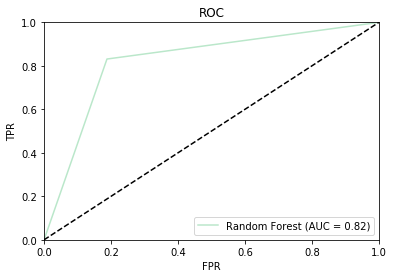

In [16]:
def plotAUC(truth, pred, lab):
    fpr, tpr, thresholds = metrics.roc_curve(truth, pred)
    roc_auc = metrics.auc(fpr, tpr)
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color=c, label= lab+' (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
plotAUC(y_test,rfPredict, 'Random Forest')
plt.show()

## extra features - acc_now_delinq, pct_tl_nvr_dlq, num_sats, sub_grade


In [17]:
 !pip install pygal

In [18]:
!pip install seaborn

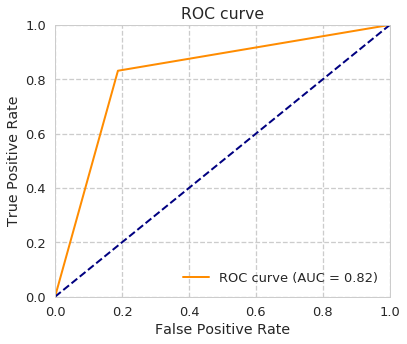

In [19]:
import seaborn as sns
sns.set('talk', 'whitegrid', 'dark', font_scale=1, font='Ricty',rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
fpr, tpr, _ = metrics.roc_curve(y_test,rfPredict)
roc_auc = metrics.auc(fpr, tpr)
lw = 2
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve') #Receiver Operating Characteristic 
plt.legend(loc="lower right")
plt.show()

## Things to be done before Initial Presentation

1. Choose the data with approximately 50% of 0's and 1's in target variable.
2. Get proper reasoning to fill the NULL values.
3. Get proper reasoning for scaling method that has to be applied.
4. Few data visualizations(loan defaulters according to state, correlation plots etc.)
5. Pick different combinations of features.
6. Apply cross validation.
7. Check for answers to potential questions.
8. Have to go through "how the company works"